<a href="https://colab.research.google.com/github/krumeto/sebra_data_playground/blob/main/SEBRA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dateparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import dateparser

In [3]:
link_to_data = "https://data.egov.bg/resource/download/zip/ba444b96-6ec3-4be7-8981-92bc33d1a94b"

In [52]:
def data_load_sebra(link_to_data):
    data = pd.read_csv(link_to_data, compression = 'zip')
    data["REG_DATE"] = pd.to_datetime(data["REG_DATE"]).dt.normalize()
    data["SETTLEMENT_DATE"] = pd.to_datetime(data["SETTLEMENT_DATE"]).dt.normalize()
    return(data)

def lowercase_columns(dataf):
    dataf.columns = dataf.columns.str.lower()
    return(dataf)

def add_year(dataf):
    return(
        dataf.assign(reg_year = dataf['reg_date'].dt.year)
        )
    
def uppercase_all_object_cols(dataf):
    object_cols = dataf.select_dtypes("object").columns
    # For loop instead of apply for memory purposes
    for col in object_cols:
      dataf[col] = dataf[col].str.upper()
    return(dataf)


def pull_government_periods():
    """A function to pull periods of different governments and prepare the info in a format for left join"""

    # Data pull from wikipedia
    governments = pd.read_html("https://bg.wikipedia.org/wiki/%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D1%82%D0%B5%D0%BB%D1%81%D1%82%D0%B2%D0%B0_%D0%BD%D0%B0_%D0%91%D1%8A%D0%BB%D0%B3%D0%B0%D1%80%D0%B8%D1%8F",
                              match = "Република България"
                              )[0]

    # better column names              
    governments.columns = ["gov_nr", "government_alias", "government_pm", "government_start_dt", "government_end_dt", "n_days", "party/coalition"]

    # Get only post-communist goverments
    post_com_index = governments.loc[lambda d: d["gov_nr"] == "Република България (от 1990 г.)"].index
    governments = governments.iloc[lambda d: d.index > post_com_index[0]]

    # Convert dates using dateparser
    governments.government_start_dt = governments.government_start_dt.apply(dateparser.parse)

    # Weird if-else, as the last cell of the wikipedia article is usually empty, but occasionally - not
    if sum(governments.government_end_dt.isna()) > 0:
      governments.government_end_dt.iloc[:-1] = governments.government_end_dt.iloc[:-1].apply(dateparser.parse)
    else:
      governments.government_end_dt = governments.government_end_dt.apply(dateparser.parse)


    # extra cautious with dates, as we will be joining on them later
    governments.government_start_dt = pd.to_datetime(governments.government_start_dt).dt.normalize()
    governments.government_end_dt = pd.to_datetime(governments.government_end_dt).dt.normalize()


    # Get data in a long format
    # Potentially there is a much cleaner way, but data is small and this works
    long_gov_df = pd.DataFrame(columns = ["date", "government_alias", "government_pm", 'party/coalition'])

    # Iter over all rows
    for ix, row in governments.iterrows():
      interim_df = pd.DataFrame(columns = ["date", 'government_alias', 'government_pm', 'party/coalition'])
      # create a date_range starting from the day after a government starts until the day it ends
      try:
        date_period = pd.date_range(start = row["government_start_dt"] + pd.Timedelta(days=1), end = row["government_end_dt"])
      # except for the NA for the latest government
      except ValueError:
        date_period = pd.date_range(start = row["government_start_dt"] + pd.Timedelta(days=1), end = pd.Timestamp.today())
      interim_df["date"] = date_period
      interim_df["government_alias"] = row["government_alias"]
      interim_df["government_pm"] = row["government_pm"]
      interim_df['party/coalition'] = row['party/coalition']
      long_gov_df = pd.concat([long_gov_df, interim_df])

    long_gov_df["date"] = pd.to_datetime(long_gov_df["date"]).dt.normalize()
    return(long_gov_df)


def pull_bank_names_per_bic():
    """A function to pull bank names for a given bic"""

    bics_raw = pd.read_html("https://www.bnb.bg/RegistersAndServices/RSBAEAndBIC/index.htm")

    # clean the raw output
    bics = pd.DataFrame()

    for dataf in bics_raw:
      if dataf.shape[1] == 3 and dataf.shape[0] > 0:
        bics = pd.concat([bics, dataf])

    # keep the bics only
    bics = bics.dropna().iloc[:, [0,2]].reset_index(drop=True)
    bics.columns = ["bank_name", "bic"]

    # Expired and additional bics
    additional_banks_list = [('Българска народна банка', 'BNBGBGSF'),
    ('Българска народна банка', 'BNBGBGSD'),
    ('СИБАНК', 'BUIBBGSF'),
    ('УниКредит Булбанк АД', 'BFTBBGSF'),
    ('Сосиете Женерал Експрес Банк', 'TTBBBG22'),
    ('Unknown bank', 'ACBPGS2P'),
    ('МКБ Юнионбанк АД', 'CBUNBGSF'),
    ('ДЗИ Банк АД', 'REXIBGSF'),
    ('Корпоративна търговска банка АД', 'KORPBGSF'),
    ('Пиреус Банк България АД', 'PIRBBGSF'),
    ('ТИ БИ АЙ БАНК ЕАД', 'WEBKBGSF'),
    ('Алфа банк - клон България', 'CRBABGSF'),
    ('Креди Агрикол България', 'BINVBGSF'),
    ('SG Експресбанк AD', 'TTBB22'),
    ('ISBANK AG', 'ISBKBGSF'),
    ('Ейч Ви Би Банк БиохимАД', 'BACXBGSF')
    ]


    additional_banks_df = pd.DataFrame(additional_banks_list, columns = ["bank_name", "bic"])

    bics = pd.concat([bics, additional_banks_df]).reset_index(drop = True)
    bics = bics.loc[lambda d: d['bic'].str.len() <= 8].reset_index(drop = True)

    return(bics)

def get_a_report_per_iban(dataf, iban):
    
    all_rows = dataf.loc[lambda d: d["client_receiver_acc"] == iban]
    n_hashes = (all_rows["client_name_hash"].unique())
    n_client_receiver_name = (all_rows["client_receiver_name"].unique())
    flows = (all_rows.
             groupby(["primary_organization", "reg_year"])['amount'].
             agg(["sum", 'count']).
             sort_values('reg_year'))
    
    return([all_rows, n_hashes, n_client_receiver_name, flows])

## Data pull

In [5]:
data = (data_load_sebra(link_to_data).
        # Lowercase columns
        pipe(lowercase_columns).
        # Add year as a separate column
        pipe(add_year).
        # Add columns for government during the period
        # joining on settlement date gets more results than on reg_date
        merge(pull_government_periods(), 
              how ='left',
              left_on ='settlement_date',
              right_on = 'date').
        drop(columns = ['date']).
        # Add bank names
        merge(pull_bank_names_per_bic(),
              how = "left",
              left_on = "client_receiver_bic",
              right_on = "bic").
        drop(columns = ['bic']).
        pipe(uppercase_all_object_cols))


In [6]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3586569 entries, 0 to 3586568
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   settlement_date       3586569 non-null  datetime64[ns]
 1   client_receiver_name  3586569 non-null  object        
 2   client_receiver_acc   3586569 non-null  object        
 3   client_receiver_bic   3586569 non-null  object        
 4   fin_code              3586569 non-null  int64         
 5   amount                3586569 non-null  float64       
 6   currency              3586569 non-null  object        
 7   reason1               3459986 non-null  object        
 8   reason2               2626159 non-null  object        
 9   reg_date              3586569 non-null  datetime64[ns]
 10  reg_no                3586569 non-null  object        
 11  sebra_pay_code        3586569 non-null  int64         
 12  organization          3586569 non-null  ob

In [7]:
data = data.pipe(uppercase_all_object_cols)

In [8]:
data.sample(10)

,settlement_date,client_receiver_name,client_receiver_acc,client_receiver_bic,fin_code,amount,currency,reason1,reason2,reg_date,...,sebra_pay_code,organization,primary_organization,primary_org_code,client_name_hash,reg_year,government_alias,government_pm,party/coalition,bank_name
246717,2008-02-21,РУСО РУСЕ,BG93UBBS80023300121138,UBBSBGSF,550030186,120000.00,BGN,1210825210143,0208 0208 ЗАХР НАБ С/КА 200208,2008-02-20,...,50,ДОО-Ф-Д ОЗМ-РУСО-РУСЕ,НОИ ? ДЪРЖАВНО ОБЩЕСТВЕНО ОСИГУРЯВА,55,EC7BBF94A0F30B59E27D11AFED32FBBCF9FBF6DC6B8BB0...,2008,СТАНИШЕВ,СЕРГЕЙ СТАНИШЕВ(РОД. 1966),"БСП, НДСВ, ДПС",ОБЕДИНЕНА БЪЛГАРСКА БАНКА АД
1228331,2013-07-25,УНИКРЕДИТ БУЛБАНК,BG54UNCR75271099959483,UNCRBGSF,550030000,936108.64,BGN,13UNCRBC.058,0713 07139121082521 240713,2013-07-24,...,40,ДОО - Ф-Д ОЗМ - НОИ-ЦУ,НОИ - ДОО,55,EA5F83E9DBCEFD7B334BD7553D5A1CC032073CE7DC0C27...,2013,ОРЕШАРСКИ,ПЛАМЕН ОРЕШАРСКИ(РОД. 1960),"БСП, ДПС[4]",УНИКРЕДИТ БУЛБАНК АД
714678,2010-12-27,ФИЗИЧЕСКО ЛИЦЕ,BG43BPBI79261060517101,BPBIBGSF,1220093218,6243.46,BGN,ПЛАЩАНЕ НА СУБСИДИИ,NaN,2010-12-23,...,30,РАЗПЛ А-ИЯ-ДИРЕКТНИ-ПЛАЩАНИЯ,"ДФ ""ЗЕМЕДЕЛИЕ""",122,77D1458DDC1201A4DDB7C7C3A4ED5BDA6151E45E3574DE...,2010,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],ЮРОБАНК БЪЛГАРИЯ АД
883125,2011-12-16,БП РУ ЗАПАДЕН РЕГИОН,BG54IORT80451000720700,IORTBGSF,230050000,9453.00,BGN,ВИНЕТНИ СТИКЕРИ,141211,2011-12-15,...,10,"ИА ""ЕЛЕКТРОННИ СЪОБЩИТЕЛНИ МРЕЖИ И ИНФОРМАЦИОН...",МИНИСТЕРСТВО НА ТРАНСПОРТА,23,C4B4882DE87E01A05451B80F69B46D5B07434A78FF0DC6...,2011,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],ИНВЕСТБАНК АД
593897,2010-03-18,ФИЗИЧЕСКО ЛИЦЕ,BG88UNCR70004517021154,UNCRBGSF,1220093239,9136.39,BGN,ПЛАЩАНЕ НА СУБСИДИИ,NaN,2010-03-17,...,30,РАЗПЛ А-ИЯ-ДИРЕКТНИ-ПЛАЩАНИЯ-ЕЗФРСР,"ДФ ""ЗЕМЕДЕЛИЕ""",122,A39999AE52F3468ACCD9521881A459E129807D73B83ECB...,2010,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],УНИКРЕДИТ БУЛБАНК АД
1374268,2014-02-26,ОУ Г. С. РАКОВСКИ КЛИМЕНТ,BG73DEMI92403100055127,DEMIBGSF,9830019174,9534.00,BGN,PO001/3.1.06 РД09 1860/11,0214 031492700237 190214,2014-02-24,...,60,МОН-ТЕХНИЧЕСКА ПОМОЩ И ДР. - ОП ЧОВЕШКИ Р-СИ-ЕСФ,НФ - ЕСФ,983,359EE932DEC02996AF248F760594B8A8DA3F8770EDA2DE...,2014,ОРЕШАРСКИ,ПЛАМЕН ОРЕШАРСКИ(РОД. 1960),"БСП, ДПС[4]",ТЪРГОВСКА БАНКА Д АД
1190559,2013-05-13,ФИЗИЧЕСКО ЛИЦЕ,BG40BNBG96611000066123,BNBGBGSD,8590000009,7698.48,BGN,NaN,",",2013-05-13,...,92,"НАЦИОНАЛНА СПОРТНА АКАДЕМИЯ ""В. ЛЕВСКИ""-ЦУ","НАЦИОНАЛНА СПОРТНА АКАДЕМИЯ ""В. ЛЕВСКИ""",859,D54D84CEDE468B5F38AD7426B2AA2846AE6D56EAABE769...,2013,РАЙКОВ,МАРИН РАЙКОВ(РОД. 1960),СЛУЖЕБЕН; НЕЗАВИСИМИ,БЪЛГАРСКА НАРОДНА БАНКА
2584390,2019-04-19,ФИЗИЧЕСКО ЛИЦЕ,BG93STSA93000017067021,STSABGSF,1220843210,7903.13,BGN,ТЮТЮН 2018,NaN,2019-04-18,...,40,ДФ ЗЕМЕДЕЛИЕ-НАЦИОНАЛНИ ДОПЛАЩАНИЯ,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,9A6F28DE3EF38FE08B0D705967B666E52D5108031901B4...,2019,БОРИСОВ 3,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, ОБЕДИНЕНИ ПАТРИОТИ",БАНКА ДСК АД
1714182,2015-09-28,СБАЛК МАДАРА ЕАД,BG65UNCR70001520137698,UNCRBGSF,560270008,251376.00,BGN,Д.N 270538/2015 0815,90000000158070915,2015-09-25,...,40,РЗОК-ШУМЕН,НЗОК,56,688696058B8E6CA20E4B9E810D8B4F8EDA05A0174A0D93...,2015,БОРИСОВ 2,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, РЕФОРМАТОРСКИ БЛОК, АБВ",УНИКРЕДИТ БУЛБАНК АД
1122160,2013-07-02,ИНВЕСТБАНК,BG53IORT73731000037301,IORTBGSF,550090056,64135.92,BGN,1210825210089 05IORT,0213 0213902.TXT 20130206,2013-06-02,...,40,ДОО-ПЕНСИИ - РУСО-ВИДИН,НОИ - ДОО,55,41536902CDEE94E08DC7A1B5F203B5E32DA6C866E7E720...,2013,ОРЕШАРСКИ,ПЛАМЕН ОРЕШАРСКИ(РОД. 1960),"БСП, ДПС[4]",ИНВЕСТБАНК АД


### Brief EDA

#### Dates differ by a day, but also by about a month, two or three months

Settlement date minus reg_date:

count    3586569.00
mean           5.11
std           58.28
min         -334.00
10%            1.00
25%            1.00
50%            1.00
75%           30.00
90%           31.00
max          359.00
dtype: float64
Most frequent delta between settlement date and reg_date:

1      1601977
31      318390
3       280297
30      270266
2       170394
0        99359
4        93987
92       92954
28       41288
61       39727
5        37595
91       31847
6        25507
122      19310
29       17279
7        15093
90       14776
123      11436
153       9693
89        9313
dtype: int64


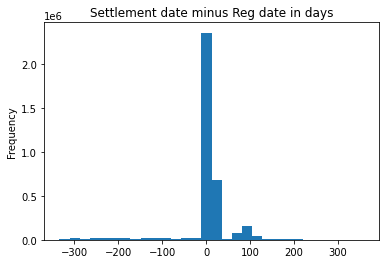

In [9]:
settlement_date_minus_reg_date = (data.settlement_date - data.reg_date).dt.days

print("Settlement date minus reg_date:\n\n", 
      (settlement_date_minus_reg_date.
      describe(percentiles = [.10, .25, .5, .75, .90]).
      round(2)), 
      sep = "")


print("Most frequent delta between settlement date and reg_date:\n\n", 
      (settlement_date_minus_reg_date.value_counts().nlargest(20)), 
      sep = "")

((settlement_date_minus_reg_date.
      plot.hist(bins =30, title = "Settlement date minus Reg date in days")))


In [10]:
# Only transfers in BGN
## TODO think of some inflation adjustments
data.currency.unique()

array(['BGN'], dtype=object)

### Biggest overall flows (not very telling)

Better to aggregate by primary_org_code and then get the main name. See different names for НОИ.

In [22]:
overall_flows = data.groupby(["primary_organization", "primary_org_code", "client_receiver_name"], as_index = False)['amount'].agg(["sum", 'count']).reset_index()

overall_flows.nlargest(20, columns = ['sum']).style.format({"sum": "{:,.0f}"})

,primary_organization,primary_org_code,client_receiver_name,sum,count
268461,НОИ - ДОО,55,БАНКА ДСК АД ЦУ ГР.СОФИЯ,"23,668,491,106",1559
271544,НОИ - ДОО,55,ОББ АД КЛ. ЦЕНТРАЛЕН,"6,501,729,692",1408
327308,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,СТОЛИЧНА ОБЩИНА,"6,001,380,848",826
159856,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,МРРБ,"5,191,383,748",1697
301575,ПРЕДПРИЯТИЕ ЗА УПРАВЛЕНИЕ НА ДЕЙНОСТИТЕ ПО ОПАЗВАНЕ НА ОКОЛНАТА СРЕДА,119,"ФОНД ""СЕЛС""","5,156,011,246",76
311600,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,НЕК ЕАД,"4,995,101,853",81
272269,НОИ - ДОО,55,ПЪРВА ИНВЕСТИЦИОННА БАНКА,"4,869,167,924",2640
273653,НОИ - ДОО,55,ТП СПС,"4,797,700,358",3153
274439,НОИ - ДОО,55,ЮРОБАНК БЪЛГАРИЯ АД,"4,444,238,403",1456
53272,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,ФИЗИЧЕСКО ЛИЦЕ,"4,361,584,058",296376


Excl. НОИ?



In [24]:
(overall_flows.loc[lambda d: d["primary_org_code"] != 55].
 nlargest(20, columns = ['sum']).
 style.format({"sum": "{:,.0f}"}))

,primary_organization,primary_org_code,client_receiver_name,sum,count
327308,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,СТОЛИЧНА ОБЩИНА,"6,001,380,848",826
159856,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,МРРБ,"5,191,383,748",1697
301575,ПРЕДПРИЯТИЕ ЗА УПРАВЛЕНИЕ НА ДЕЙНОСТИТЕ ПО ОПАЗВАНЕ НА ОКОЛНАТА СРЕДА,119,"ФОНД ""СЕЛС""","5,156,011,246",76
311600,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,НЕК ЕАД,"4,995,101,853",81
53272,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,ФИЗИЧЕСКО ЛИЦЕ,"4,361,584,058",296376
324012,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,ОБЩИНА ПЛОВДИВ,"2,009,567,216",608
323642,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,ОБЩИНА ВАРНА,"1,874,841,944",633
35168,"ДФ ""ЗЕМЕДЕЛИЕ""",122,ФИЗИЧЕСКО ЛИЦЕ,"1,764,410,206",108355
312131,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,ФСЕЛС,"1,584,211,887",60
156451,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,АВТОМАГИСТРАЛИ ЕАД,"1,400,825,688",516


## Top individuals per amount transferred

Most of the top individual's seem to be just some organization using a personal name for a number of transfers.

In [26]:
(data.
 loc[(data["client_receiver_name"] == "ФИЗИЧЕСКО ЛИЦЕ")].
 groupby(["client_receiver_acc", "bank_name"])['amount'].
 agg(["sum", 'count']).
 sort_values('sum', ascending = False).
 head(20).
 style.format("{:,.0f}")
 )

,,sum,count
client_receiver_acc,bank_name,,
BG40BNBG96611000066123,БЪЛГАРСКА НАРОДНА БАНКА,"285,715,372","9,980"
BG95BPBI79421076516501,ЮРОБАНК БЪЛГАРИЯ АД,"262,899,263",19
BG52RZBB91553120008113,КЕЙ БИ СИ БАНК БЪЛГАРИЯ ЕАД,"57,932,168",98
BG26RZBB91553100055002,КЕЙ БИ СИ БАНК БЪЛГАРИЯ ЕАД,"44,503,471",136
BG86TTBB94001525796131,СОСИЕТЕ ЖЕНЕРАЛ ЕКСПРЕС БАНК,"24,315,169",255
BG27KORP92201000000100,КОРПОРАТИВНА ТЪРГОВСКА БАНКА АД,"16,489,738",9
BG94BPBI79421022439601,ЮРОБАНК БЪЛГАРИЯ АД,"14,583,000",1
BG28BUIN72201010650432,АЛИАНЦ БАНК БЪЛГАРИЯ АД,"13,409,529",48
BG34UNCR70001500193116,УНИКРЕДИТ БУЛБАНК АД,"12,558,646",168


In [54]:
# This one seems just a BNB IBAN
get_a_report_per_iban(data,"BG40BNBG96611000066123")

[        settlement_date             client_receiver_name  \
 0            2006-06-06          БЪЛГАРСКА НАРОДНА БАНКА   
 33           2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 345          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 346          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 347          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 ...                 ...                              ...   
 3580248      2022-06-24      МИНИСТЕРСТВО НА ЗЕМЕДЕЛИЕТО   
 3580898      2022-06-24                             УАСГ   
 3581135      2022-06-27  М ВО НА ОБРАЗОВАНИЕТО И НАУКАТА   
 3583660      2022-06-27       БЪЛГАРСКО НАЦИОНАЛНО РАДИО   
 3583839      2022-06-27             МГУ "СВ.ИВАН РИЛСКИ"   
 
             client_receiver_acc client_receiver_bic    fin_code     amount  \
 0        BG40BNBG96611000066123            BNBGBGSD   100000004   10000.00   
 33       BG40BNBG96611000066123            BNBGBGSD   100000004   10000.00   
 345      BG40BNBG96611000066

In [51]:
# This one seems just БДЖ
get_a_report_per_iban(data,"BG95BPBI79421076516501")

[        settlement_date         client_receiver_name     client_receiver_acc  \
 1126368      2013-02-14               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1126369      2013-02-14               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1154496      2013-03-13               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1170181      2013-10-04               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1189348      2013-10-05               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 ...                 ...                          ...                     ...   
 2404239      2018-07-08  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2422858      2018-11-09  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2439940      2018-12-10  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2457670      2018-12-11  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2470524      2018-11-30  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 
         client_receiver_b

In [49]:
# This is just Rakitovo's municipality
get_a_report_per_iban(data, "BG52RZBB91553120008113")

[        settlement_date client_receiver_name     client_receiver_acc  \
 2582835      2019-04-19         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 2584642      2019-04-19       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2591031      2019-04-24       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2606842      2019-07-05       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2608373      2019-09-05       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 ...                 ...                  ...                     ...   
 3561640      2022-06-06       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 3566693      2022-06-15         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3577206      2022-06-20         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3577900      2022-06-21         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3583777      2022-06-27       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 
         client_receiver_bic    fin_code      amount currency  \
 2582835            RZBBBGSF   153000004    27782.92     

In [53]:
# This is just Troyan's municipality
get_a_report_per_iban(data, "BG26RZBB91553100055002")

[        settlement_date client_receiver_name     client_receiver_acc  \
 2200601      2017-03-11       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2202794      2017-07-11       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2207136      2017-11-15       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2209880      2017-11-22      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 2212311      2017-11-27       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 ...                 ...                  ...                     ...   
 3542892      2022-05-19      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3564694      2022-10-06       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 3566684      2022-06-15      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3577210      2022-06-20      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3580839      2022-06-24       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 
         client_receiver_bic    fin_code     amount currency  \
 2200601            RZBBBGSF  4442490000  460000.00      B

## Some work on vectorizing the transfer reasons